### Regression notebook for Wadhwani AI competition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib
import torch
from torch.utils.data import Dataset, DataLoader
import transformers
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import timm
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2,torchvision
from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
from timm.optim.optim_factory import create_optimizer_v2
from timm import utils
from fastprogress.fastprogress import format_time
from fastai.vision.all import *


class CFG:
    seed = 46
    n_splits = 10
    SZ = 1024  # 1280
    debug = False
    BS = 24
    EP = 10
    MODEL = 'tf_efficientnet_b0_ns'
    LR = 5e-03
    WD = 1e-08

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)
plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

In [3]:
set_seed(CFG.seed)

In [4]:
DIR = '///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/'
IMG_PATH = '///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/images'
submit = pd.read_csv(os.path.join(DIR,'SampleSubmission.csv'))
train = pd.read_csv(os.path.join(DIR,'Train.csv'))
test_df = pd.read_csv(os.path.join(DIR,'Test.csv'))

VERSION = "NB_EXP_V0_005"
MODEL_FOLDER = Path(f"///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/runs/Regression/{VERSION}/")
os.makedirs(MODEL_FOLDER,exist_ok=True)
KERNEL_TYPE = f"{CFG.MODEL}_{CFG.SZ}_bs{CFG.BS}_ep{CFG.EP}_lr{str(CFG.LR).replace('-','')}_wd{str(CFG.WD).replace('-','')}"

print(MODEL_FOLDER)
print(KERNEL_TYPE)

/mnt/c/Personal/Competitions/Zindi/Wadhwani AI/models/NB_EXP_V0_001
tf_efficientnet_b1_ns_1024_bs16_ep10_lr0.005_wd1e08


In [5]:
def make_train_dataset():
    train_new_pbw = pd.DataFrame()
    train_new_pbw['image_id_worm']= train['image_id_worm'].unique()
    train_new_pbw = pd.merge(train_new_pbw,train[train['worm_type']=='pbw'].reset_index(drop=True),on='image_id_worm',how='left')
    train_new_pbw['worm_type'] = 'pbw'
    train_new_pbw.fillna(0,inplace=True)
    
    train_new_abw = pd.DataFrame()
    train_new_abw['image_id_worm']= train['image_id_worm'].unique()
    train_new_abw = pd.merge(train_new_abw,train[train['worm_type']=='abw'].reset_index(drop=True),on='image_id_worm',how='left')
    train_new_abw['worm_type'] = 'abw'
    train_new_abw.fillna(0,inplace=True)
    
    train_out = pd.concat([train_new_pbw,train_new_abw],0).reset_index(drop=True)
    
    assert len(train_out) == train['image_id_worm'].nunique()*2
    train_out = pd.pivot(train_out,'image_id_worm','worm_type','number_of_worms').reset_index()
    train_out[['abw','pbw']] = train_out[['abw','pbw']].astype(int)
    
    labels = [f'{i}' for i in range(10)]
    train_out['abw_bins'] = pd.cut(train_out['abw'],10,labels=labels)
    train_out['pbw_bins'] = pd.cut(train_out['pbw'],10,labels=labels)
    train_out['consol_bins'] = train_out['abw_bins'].astype(str)+'_'+train_out['pbw_bins'].astype(str)
    
#     train_out = train_out[['image_id_worm','abw','pbw','abw_bins','pbw_bins','consol_bins']]
    return train_out

train_new = make_train_dataset()

In [6]:
train_new.head(1)

worm_type,image_id_worm,abw,pbw,abw_bins,pbw_bins,consol_bins
0,id_0002ea6f15c7fa6f4c221783.jpg,0,51,0,0,0_0


### Get kfolds

In [7]:
mskf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=42)
fold_ids = []
train_new['fold'] = 0

for train_index, test_index in mskf.split(train_new, train_new['consol_bins']):
    fold_ids.append(test_index)
    
for fld in range(CFG.n_splits):
    valIx = fold_ids[fld]
    train_new.loc[valIx,'fold']=fld 

In [8]:
train_new.head()

worm_type,image_id_worm,abw,pbw,abw_bins,pbw_bins,consol_bins,fold
0,id_0002ea6f15c7fa6f4c221783.jpg,0,51,0,0,0_0,3
1,id_0005ef295aafe6acc63587db.jpg,0,8,0,0,0_0,4
2,id_00084298dd030a500033ff78.jpg,0,0,0,0,0_0,3
3,id_00093f2c76f6488737325859.jpg,0,12,0,0,0_0,1
4,id_000b2e6c437c643f25d4a6c3.jpg,0,87,0,1,0_1,2


In [9]:
test_df.head(1)

,image_id_worm
0,id_00332970f80fa9a47a39516d.jpg


#### Data loader

In [10]:
IMG_PATH

'///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/images'

In [11]:
class WadhwaniDataset(Dataset):
    def __init__(self,
                 df=train_new,
                 mode='train',
                augs = None):
        
        self.augs = augs
        self.df = df
        self.mode  = mode
        
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, ix):
        image_id = self.df.loc[ix,'image_id_worm']
        img_path = f'{IMG_PATH}/{image_id}'
        
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)
        
        if self.augs is not None:
            img = self.augs(image=img)['image']
    
        if self.mode == 'test':
            return img
        
        label = torch.tensor(self.df[['abw','pbw']].loc[ix]).float()
#         label_pbw = torch.tensor(self.df['pbw'].loc[ix]).long()
        return img, label

In [12]:
def worker_init_fn(worker_id):
    """
    Handles PyTorch x Numpy seeding issues.
    Args:
        worker_id (int): Id of the worker.
    """
    np.random.seed(np.random.get_state()[1][0] + worker_id)

### Augmentations

In [13]:

TRAIN_AUG = A.Compose([
#     A.RandomResizedCrop(height=SZ, width=SZ, p=1.0, scale=(0.72, 1.0)),
#     A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(rotate_limit=45, border_mode=0, p=0.75),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
    A.Blur(p=0.5),
#     A.CoarseDropout(max_height=int(32*(CFG.SZ/512)), max_width=int(32*(CFG.SZ/512)), p=0.75),
    A.Resize(CFG.SZ,CFG.SZ,p=1),
    A.Normalize(),
    ToTensorV2(),
])

VALID_AUG = A.Compose([
#     A.SmallestMaxSize(max_size=CFG.SZ + 16, p=1.0),
#     A.CenterCrop(height=CFG.SZ, width=CFG.SZ, p=1.0),
    A.Resize(CFG.SZ,CFG.SZ,p=1),
    A.Normalize(),
    ToTensorV2(),
])

### Visualization

<AxesSubplot: >

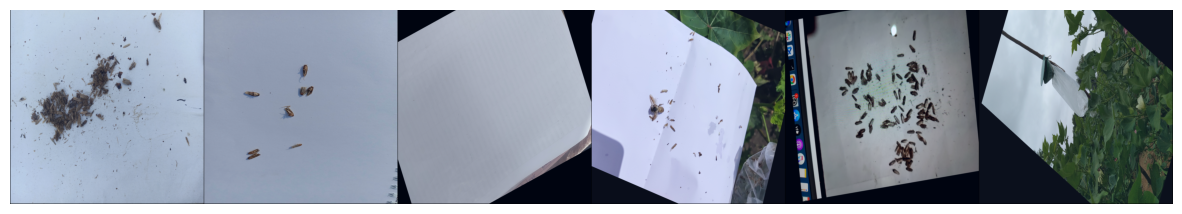

In [14]:
dataset_show = WadhwaniDataset(train_new, augs=TRAIN_AUG, mode='train')
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=6)
img,target = next(iter(loader_show))

grid = torchvision.utils.make_grid(img, normalize=True, padding=2)
grid = grid.permute(1, 2, 0)
show_image(grid, figsize=(15,8))#, title=[labels_class_map_rev[x] for x in target.numpy()]);

### Model

In [15]:
def get_wadhwani_regression_model(model_name, pretrained=True, **kwargs):
    model = timm.create_model(model_name, pretrained=pretrained, **kwargs)
    #model.set_grad_checkpointing(enable=True)
    model = nn.Sequential(model, nn.Dropout(0.15), nn.Linear(model.num_classes, 2),nn.ReLU())
    return model

In [16]:
dl = DataLoader(WadhwaniDataset(train_new, augs=TRAIN_AUG, mode='train'),
                          batch_size=2,
                          shuffle=True,
                          num_workers=8,
                          drop_last=True,
                        worker_init_fn=worker_init_fn)

a,b = next(iter(dl))
a.shape,b[0].shape,b[1].shape

(torch.Size([2, 3, 1024, 1024]), torch.Size([2]), torch.Size([2]))

In [17]:
m = get_wadhwani_regression_model(CFG.MODEL)
out = m(a)
print(out, out.shape)

tensor([[0.0924, 0.1056],
        [0.0321, 0.1100]], grad_fn=<ReluBackward0>) torch.Size([2, 2])


In [18]:
nn.L1Loss()(out,b).item()

2.227207660675049

### Train & Validation Function

In [19]:
# class CombinedL1Loss:
#     "Dice and Focal combined"
#     def __init__(self, axis=1, smooth=1., alpha=0.5):
#         store_attr()
#         self.loss1 = torch.nn.L1Loss()
#         self.loss2 =  torch.nn.L1Loss()
        
#     def __call__(self, pred, targ):
#         loss = self.loss1(pred[0], targ[0]) + self.dice_loss(pred[1], targ[1])
#         return loss
    
#     def decodes(self, x):    return x.argmax(dim=self.axis)
#     def activation(self, x): return F.softmax(x, dim=self.axis)

In [20]:
def train_one_epoch(
    model: nn.Module,
    loader: Iterable,
    loss_fn: Callable,
    optimizer: torch.optim.Optimizer,
    lr_scheduler: torch.optim.lr_scheduler._LRScheduler = None,
    mixup_fn: Callable = None,
    grad_scaler: torch.cuda.amp.GradScaler = None,
    mbar: master_bar = None,
):

    model.train()

    losses_m = utils.AverageMeter()

    pbar = progress_bar(loader, parent=mbar, leave=False)
    pbar.update(0)

    for batch_idx, (input, target) in enumerate(loader):
        input, target = input.cuda(), target.cuda()
        
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            output = model(input)
            loss = loss_fn(output, target)
            
        losses_m.update(loss.item(), input.size(0))

        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()

        if lr_scheduler is not None:
            lr_scheduler.step()

        pbar.update(batch_idx + 1)
        pbar.comment = f"{losses_m.avg:.4f}"

    pbar.on_iter_end()
    return OrderedDict([("loss", losses_m.avg)])


@torch.inference_mode()
def validate(model: nn.Module, loader: Iterable, loss_fn: Callable, mbar: master_bar):
    model.eval()

    l1_loss_m = utils.AverageMeter()
    losses_m = utils.AverageMeter()

    pbar = progress_bar(loader, parent=mbar, leave=False)
    pbar.update(0)

    for batch_idx, (input, target) in enumerate(loader):
        
        input, target = input.cuda(), target.cuda()
        output = torch.round(model(input))

        loss = loss_fn(output, target).item()
        losses_m.update(loss, input.size(0))

        l1_loss = nn.L1Loss()(output, target).item()
        l1_loss_m.update(l1_loss, output.size(0))

        pbar.update(batch_idx + 1)

    pbar.on_iter_end()
    return OrderedDict([("loss", losses_m.avg), ("l1_loss", l1_loss_m.avg)])


### Run!

In [21]:
def training_loop(fold):
    
    if fold>0:
        time.sleep(5*60)
    
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        print()
        print("*" * 100)
        print(f"Training fold {fold}")
        print("*" * 100)

        torch.backends.cudnn.benchmark = True

        dataset_train = WadhwaniDataset(train_new.query("fold!=@fold").reset_index(drop=True), augs=TRAIN_AUG, mode="train")
        dataset_valid = WadhwaniDataset(train_new.query("fold==@fold").reset_index(drop=True), augs=VALID_AUG, mode="valid")

        print(f"TRAIN: {len(dataset_train)} | VALID: {len(dataset_valid)}")

        loader_train = torch.utils.data.DataLoader(dataset_train, CFG.BS, num_workers=8, shuffle=True, drop_last=True)
        loader_valid = torch.utils.data.DataLoader(dataset_valid, CFG.BS * 2, num_workers=8, shuffle=False)

        model = get_wadhwani_regression_model(CFG.MODEL, pretrained=True, drop_path_rate=0.15)
        model.cuda()
        # adamw
        optimizer = create_optimizer_v2(model, "lookahead_RAdam", lr=CFG.LR, weight_decay=CFG.WD, layer_decay=0.9)

        num_train_steps = len(loader_train) * CFG.EP
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_train_steps)

        train_loss_fn = nn.L1Loss()
        valid_loss_fn = nn.L1Loss()

        grad_scaler = torch.cuda.amp.GradScaler()

        print(f"Scheduled epochs: {CFG.EP}")

        mbar = master_bar(list(range(CFG.EP)))
        best_epoch, best_metric = 0, 100000
        metric_names = ["epoch", "train_loss", "valid_loss", "l1_loss", "time"]
        mbar.write([f"{l:.6f}" if isinstance(l, float) else str(l) for l in metric_names], table=True)

        for epoch in range(CFG.EP):
            start_time = time.time()
            mbar.update(epoch)

            train_metrics = train_one_epoch(
                model, loader_train, train_loss_fn, optimizer,
                lr_scheduler=lr_scheduler, mixup_fn=None, grad_scaler=grad_scaler, mbar=mbar)

            valid_metrics = validate(model, loader_valid, valid_loss_fn, mbar=mbar)
            
            elapsed = format_time(time.time() - start_time)
            epoch_log = [epoch,train_metrics["loss"], valid_metrics["loss"], valid_metrics["l1_loss"], elapsed]
            mbar.write([f"{l:.6f}" if isinstance(l, float) else str(l) for l in epoch_log], table=True)

            if valid_metrics["l1_loss"] < best_metric:
                best_epoch, best_metric = epoch, valid_metrics["l1_loss"]
                dirpath = MODEL_FOLDER / (KERNEL_TYPE + f"_CV_{fold}.pth")
                torch.save(model.state_dict(), dirpath)

        mbar.on_iter_end()
        print("*** Best metric: {0} (epoch {1})".format(best_metric, best_epoch))

In [22]:
# for fold_idx in range(CFG.n_splits):
#     training_loop(fold_idx)

In [23]:
### 3.03 - eb0 fold 0 1024 sz

### Inference

In [24]:
for i in range(5):
    torch.cuda.empty_cache()
    gc.collect()

In [26]:
test_df.head(1)

,image_id_worm
0,id_00332970f80fa9a47a39516d.jpg


In [27]:
# ========================================
# INFERENCE LOOP
# ========================================
test_ds = WadhwaniDataset(test_df, augs=VALID_AUG, mode="test")
test_dl = torch.utils.data.DataLoader(test_ds, 16, num_workers=8, shuffle=False, pin_memory=True)
print('Test size: {}'.format(len(test_dl.dataset)))
    
preds = []
imageids = []

for input in tqdm(test_dl, dynamic_ncols=True, desc="Predicting"):
    pred = []
    with torch.cuda.amp.autocast(), torch.no_grad():
        input = input.cuda()
        for fold in range(5):
            model = get_wadhwani_regression_model(CFG.MODEL, pretrained=False)
            model.load_state_dict(torch.load(f'{MODEL_FOLDER}/tf_efficientnet_b1_ns_1024_bs16_ep10_lr0.005_wd1e08_CV_{fold}.pth'))
            model.eval()
            model.cuda()
            pred.append(model(input))
            pred.append(model(torch.flip(input, dims=(3,))))
            pred.append(model(torch.flip(input, dims=(2,))))
            pred.append(model(torch.flip(input, dims=(2, 3))))
            
            torch.cuda.empty_cache()
            gc.collect()
    pred = torch.mean(torch.stack(pred, -1),-1).data.cpu().numpy()
    preds.append(pred)
    
preds = np.round(np.concatenate(preds, axis=0))

Test size: 2803


Predicting:   0%|                                                                               | 0/176 [00:00…

In [28]:
preds_df = pd.concat([test_df,pd.DataFrame(preds)],1)
preds_df.rename(columns={0:'abw',1:'pbw'},inplace=True)
preds_melt = pd.melt(preds_df, id_vars='image_id_worm', value_vars=['abw','pbw'], var_name=None, value_name='value')
preds_melt['image_id_worm_split'] = preds_melt['image_id_worm'].apply(lambda x: x.split(".")[0])+"_"+preds_melt['variable']
preds_melt.head()

,image_id_worm,variable,value,image_id_worm_split
0,id_00332970f80fa9a47a39516d.jpg,abw,4.0,id_00332970f80fa9a47a39516d_abw
1,id_0035981bc3ae42eb5b57a317.jpg,abw,0.0,id_0035981bc3ae42eb5b57a317_abw
2,id_005102f664b820f778291dee.jpg,abw,9.0,id_005102f664b820f778291dee_abw
3,id_0066456f5fb2cd858c69ab39.jpg,abw,5.0,id_0066456f5fb2cd858c69ab39_abw
4,id_007159c1fa015ba6f394deeb.jpg,abw,0.0,id_007159c1fa015ba6f394deeb_abw


In [30]:
gc.collect()

0

In [31]:
del _

In [32]:
submit.head(1)

,image_id_worm,number_of_worms
0,id_00332970f80fa9a47a39516d_abw,0


In [33]:
submit.drop('number_of_worms',1,inplace=True)
preds_melt.rename(columns={'value':'number_of_worms'},inplace=True)
submit = pd.merge(submit,preds_melt[['image_id_worm_split','number_of_worms']],
                  left_on='image_id_worm',right_on='image_id_worm_split',how='left')

In [34]:
submit.head()

,image_id_worm,image_id_worm_split,number_of_worms
0,id_00332970f80fa9a47a39516d_abw,id_00332970f80fa9a47a39516d_abw,4.0
1,id_00332970f80fa9a47a39516d_pbw,id_00332970f80fa9a47a39516d_pbw,0.0
2,id_0035981bc3ae42eb5b57a317_abw,id_0035981bc3ae42eb5b57a317_abw,0.0
3,id_0035981bc3ae42eb5b57a317_pbw,id_0035981bc3ae42eb5b57a317_pbw,16.0
4,id_005102f664b820f778291dee_abw,id_005102f664b820f778291dee_abw,9.0


In [36]:
submit.tail(20)

,image_id_worm,image_id_worm_split,number_of_worms
5586,id_ff1ab253ae19e92a44acba7f_abw,id_ff1ab253ae19e92a44acba7f_abw,0.0
5587,id_ff1ab253ae19e92a44acba7f_pbw,id_ff1ab253ae19e92a44acba7f_pbw,0.0
5588,id_ff32de4748412b3ff320a343_abw,id_ff32de4748412b3ff320a343_abw,0.0
5589,id_ff32de4748412b3ff320a343_pbw,id_ff32de4748412b3ff320a343_pbw,6.0
5590,id_ff3b7cb6761f3d632e1ff577_abw,id_ff3b7cb6761f3d632e1ff577_abw,0.0
5591,id_ff3b7cb6761f3d632e1ff577_pbw,id_ff3b7cb6761f3d632e1ff577_pbw,0.0
5592,id_ff40ad3bb245a697d799eeef_abw,id_ff40ad3bb245a697d799eeef_abw,11.0
5593,id_ff40ad3bb245a697d799eeef_pbw,id_ff40ad3bb245a697d799eeef_pbw,0.0
5594,id_ff6b60935a327d1c2779bc5e_abw,id_ff6b60935a327d1c2779bc5e_abw,0.0
5595,id_ff6b60935a327d1c2779bc5e_pbw,id_ff6b60935a327d1c2779bc5e_pbw,0.0


In [40]:
submit.drop('image_id_worm_split',1,inplace=True)
submit.to_csv(f'{MODEL_FOLDER}/submit.csv',index=False)

### Fin 